<a href="https://colab.research.google.com/github/cannedhedgehog/Saturday/blob/main/Nasarov_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Результаты нечеткого вывода (Mamdani, вручную) ===

Сценарий: Короткая, низкая скорость, малый бюджет
  Входы: Дальность=20 км, Скорость=40 км/ч, Бюджет=5$
  Числовая оценка транспорта: 8.34 (шкала 0..100)
  Рекомендованный вид транспорта: Автобус

Сценарий: Короткая, высокая скорость, средний бюджет
  Входы: Дальность=30 км, Скорость=140 км/ч, Бюджет=60$
  Числовая оценка транспорта: 35.00 (шкала 0..100)
  Рекомендованный вид транспорта: Автомобиль

Сценарий: Средняя, умеренная скорость, средний бюджет
  Входы: Дальность=150 км, Скорость=90 км/ч, Бюджет=80$
  Числовая оценка транспорта: 60.00 (шкала 0..100)
  Рекомендованный вид транспорта: Поезд

Сценарий: Длинная, высокая скорость, высокий бюджет
  Входы: Дальность=800 км, Скорость=160 км/ч, Бюджет=300$
  Числовая оценка транспорта: 85.00 (шкала 0..100)
  Рекомендованный вид транспорта: Самолет

Сценарий: Средняя, высокая скорость, низкий бюджет
  Входы: Дальность=200 км, Скорость=140 км/ч, Бюджет=10$
  Числовая оценка транспорт

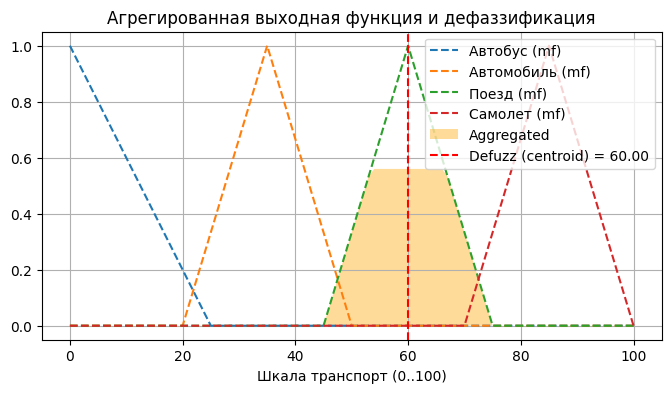

Демонстрация для входов:
  Дальность=120 км, Скорость=100 км/ч, Бюджет=80$
  -> Рекомендация: Поезд, значение (centroid)=60.00


In [31]:
# Установка (если требуется)
!pip install -q scikit-fuzzy

# -------------------------
# Решение Мамдани вручную
# Вариант 21: Выбор транспорта
# -------------------------
import numpy as np
import skfuzzy as fuz
import matplotlib.pyplot as plt

# -------------------------
# 1) Универсумы (шкалы)
# -------------------------
distance_u = np.arange(0, 501, 1)   # км
speed_u = np.arange(0, 201, 1)      # км/ч
budget_u = np.arange(0, 501, 1)     # $
transport_u = np.arange(0, 101, 1)  # условная шкала для транспорта (0..100)

# -------------------------
# 2) Функции принадлежности (треугольные, трапециевидные, гаусс)
#    - distance: треугольные
#    - speed: гаусс
#    - budget: трапециевидные
#    - transport (выход): треугольные
# -------------------------

# distance
dist_short = fuz.trimf(distance_u, [0, 0, 50])
dist_mid = fuz.trimf(distance_u, [50, 175, 300])
dist_long = fuz.trimf(distance_u, [250, 400, 500])

# speed (gaussmf)
speed_low = fuz.gaussmf(speed_u, mean=30, sigma=20)
speed_med = fuz.gaussmf(speed_u, mean=90, sigma=25)
speed_high = fuz.gaussmf(speed_u, mean=150, sigma=25)

# budget (trapmf)
budget_low = fuz.trapmf(budget_u, [0, 0, 10, 50])
budget_mid = fuz.trapmf(budget_u, [30, 80, 150, 250])
budget_high = fuz.trapmf(budget_u, [150, 300, 500, 500])

# transport (output terms)
transport_bus = fuz.trimf(transport_u, [0, 0, 25])
transport_car = fuz.trimf(transport_u, [20, 35, 50])
transport_train = fuz.trimf(transport_u, [45, 60, 75])
transport_plane = fuz.trimf(transport_u, [70, 85, 100])

# словарь для удобства
transport_mfs = {
    "Автобус": transport_bus,
    "Автомобиль": transport_car,
    "Поезд": transport_train,
    "Самолет": transport_plane,
}

# -------------------------
# Функция: выполнить Mamdani вручную для 1 набора входов
# -------------------------
def mamdani_transport(distance_val, speed_val, budget_val, do_plot=False):
    """
    Выполняет Mamdani inference вручную и возвращает:
    (crisp_value, recommended_label, aggregated_mf)
    """
    # --- Фаззификация (интерполяция степени принадлежности) ---
    d_short_deg = fuz.interp_membership(distance_u, dist_short, distance_val)
    d_mid_deg = fuz.interp_membership(distance_u, dist_mid, distance_val)
    d_long_deg = fuz.interp_membership(distance_u, dist_long, distance_val)

    s_low_deg = fuz.interp_membership(speed_u, speed_low, speed_val)
    s_med_deg = fuz.interp_membership(speed_u, speed_med, speed_val)
    s_high_deg = fuz.interp_membership(speed_u, speed_high, speed_val)

    b_low_deg = fuz.interp_membership(budget_u, budget_low, budget_val)
    b_med_deg = fuz.interp_membership(budget_u, budget_mid, budget_val)
    b_high_deg = fuz.interp_membership(budget_u, budget_high, budget_val)

    # --- Правила (каждое правило возвращает силу fired_strength) ---
    # Правила по формулировке задачи:
    # rule1: short & low_speed -> bus
    r1 = min(d_short_deg, s_low_deg)              # автобус

    # rule2: short & high_speed -> car
    r2 = min(d_short_deg, s_high_deg)             # автомобиль

    # rule3: mid & med_speed -> train
    r3 = min(d_mid_deg, s_med_deg)                # поезд

    # rule4: long & high_speed -> plane
    r4 = min(d_long_deg, s_high_deg)              # самолет

    # rule5: budget low -> bus
    r5 = b_low_deg                                # автобус

    # Доп. правила:
    # rule6: budget mid & distance long -> train
    r6 = min(b_med_deg, d_long_deg)               # поезд

    # rule7: budget high & speed high -> plane
    r7 = min(b_high_deg, s_high_deg)              # самолет

    # Соберём все правила как (strength, consequent_label)
    rules = [
        (r1, "Автобус"),
        (r2, "Автомобиль"),
        (r3, "Поезд"),
        (r4, "Самолет"),
        (r5, "Автобус"),
        (r6, "Поезд"),
        (r7, "Самолет"),
    ]

    # --- Импликация (Mamdani): для каждого правила "отрезаем" функцию следствия по силе ---
    aggregated = np.zeros_like(transport_u, dtype=float)

    for strength, label in rules:
        if strength <= 0:
            continue
        consequent_mf = transport_mfs[label]
        clipped = np.fmin(strength, consequent_mf)  # усечение (min)
        aggregated = np.fmax(aggregated, clipped)   # агрегация (max)

    # Если aggregated нулевой (никакое правило не сработало) — обработка
    if np.all(aggregated == 0):
        # Не сработало ни одно правило — возвращаем None и агрегацию нулей
        return None, None, aggregated

    # --- Дефаззификация (центроид) ---
    crisp = fuz.defuzz(transport_u, aggregated, 'centroid')
    # вычислим степень принадлежности defuzz-значения к каждому выходному терму
    degrees_at_crisp = {
        name: fuz.interp_membership(transport_u, mf, crisp)
        for name, mf in transport_mfs.items()
    }
    # выберем метку с наибольшей степенью принадлежности в точке crisp
    recommended = max(degrees_at_crisp.items(), key=lambda x: x[1])[0]

    # При желании — отобразить агрегированную функцию
    if do_plot:
        plt.figure(figsize=(8, 4))
        plt.plot(transport_u, transport_bus, '--', label="Автобус (mf)")
        plt.plot(transport_u, transport_car, '--', label="Автомобиль (mf)")
        plt.plot(transport_u, transport_train, '--', label="Поезд (mf)")
        plt.plot(transport_u, transport_plane, '--', label="Самолет (mf)")
        plt.fill_between(transport_u, 0, aggregated, facecolor='orange',
                         alpha=0.4, label='Aggregated')
        plt.axvline(crisp, color='red', linestyle='--',
                    label=f'Defuzz (centroid) = {crisp:.2f}')
        plt.title("Агрегированная выходная функция и дефаззификация")
        plt.xlabel("Шкала транспорт (0..100)")
        plt.legend()
        plt.grid(True)
        plt.show()

    return crisp, recommended, aggregated

#  Примеры запуска: несколько сценариев
scenarios = [
    ("Короткая, низкая скорость, малый бюджет", 20, 40, 5),
    ("Короткая, высокая скорость, средний бюджет", 30, 140, 60),
    ("Средняя, умеренная скорость, средний бюджет", 150, 90, 80),
    ("Длинная, высокая скорость, высокий бюджет", 800, 160, 300),
    ("Средняя, высокая скорость, низкий бюджет", 200, 140, 10),
]

print("=== Результаты нечеткого вывода (Mamdani, вручную) ===\n")
for desc, dval, sval, bval in scenarios:
    crisp, rec, agg = mamdani_transport(dval, sval, bval, do_plot=False)
    print(f"Сценарий: {desc}")
    print(f"  Входы: Дальность={dval} км, Скорость={sval} км/ч, Бюджет={bval}$")
    if crisp is None:
        print("  Ни одно правило не сработало — нет рекомендации.\n")
    else:
        print(f"  Числовая оценка транспорта: {crisp:.2f} (шкала 0..100)")
        print(f"  Рекомендованный вид транспорта: {rec}\n")


#  Демонстрация для одного выбранного примера с графиком
# Запустим с конкретными числовыми входами и визуализируем агрегированную mf
d_test, s_test, b_test = 120, 100, 80
crisp, rec, agg = mamdani_transport(d_test, s_test, b_test, do_plot=True)
print("Демонстрация для входов:")
print(f"  Дальность={d_test} км, Скорость={s_test} км/ч, Бюджет={b_test}$")
print(f"  -> Рекомендация: {rec}, значение (centroid)={crisp:.2f}")
